In [684]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plot
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [685]:
def rosenbrock_func(x, y):
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

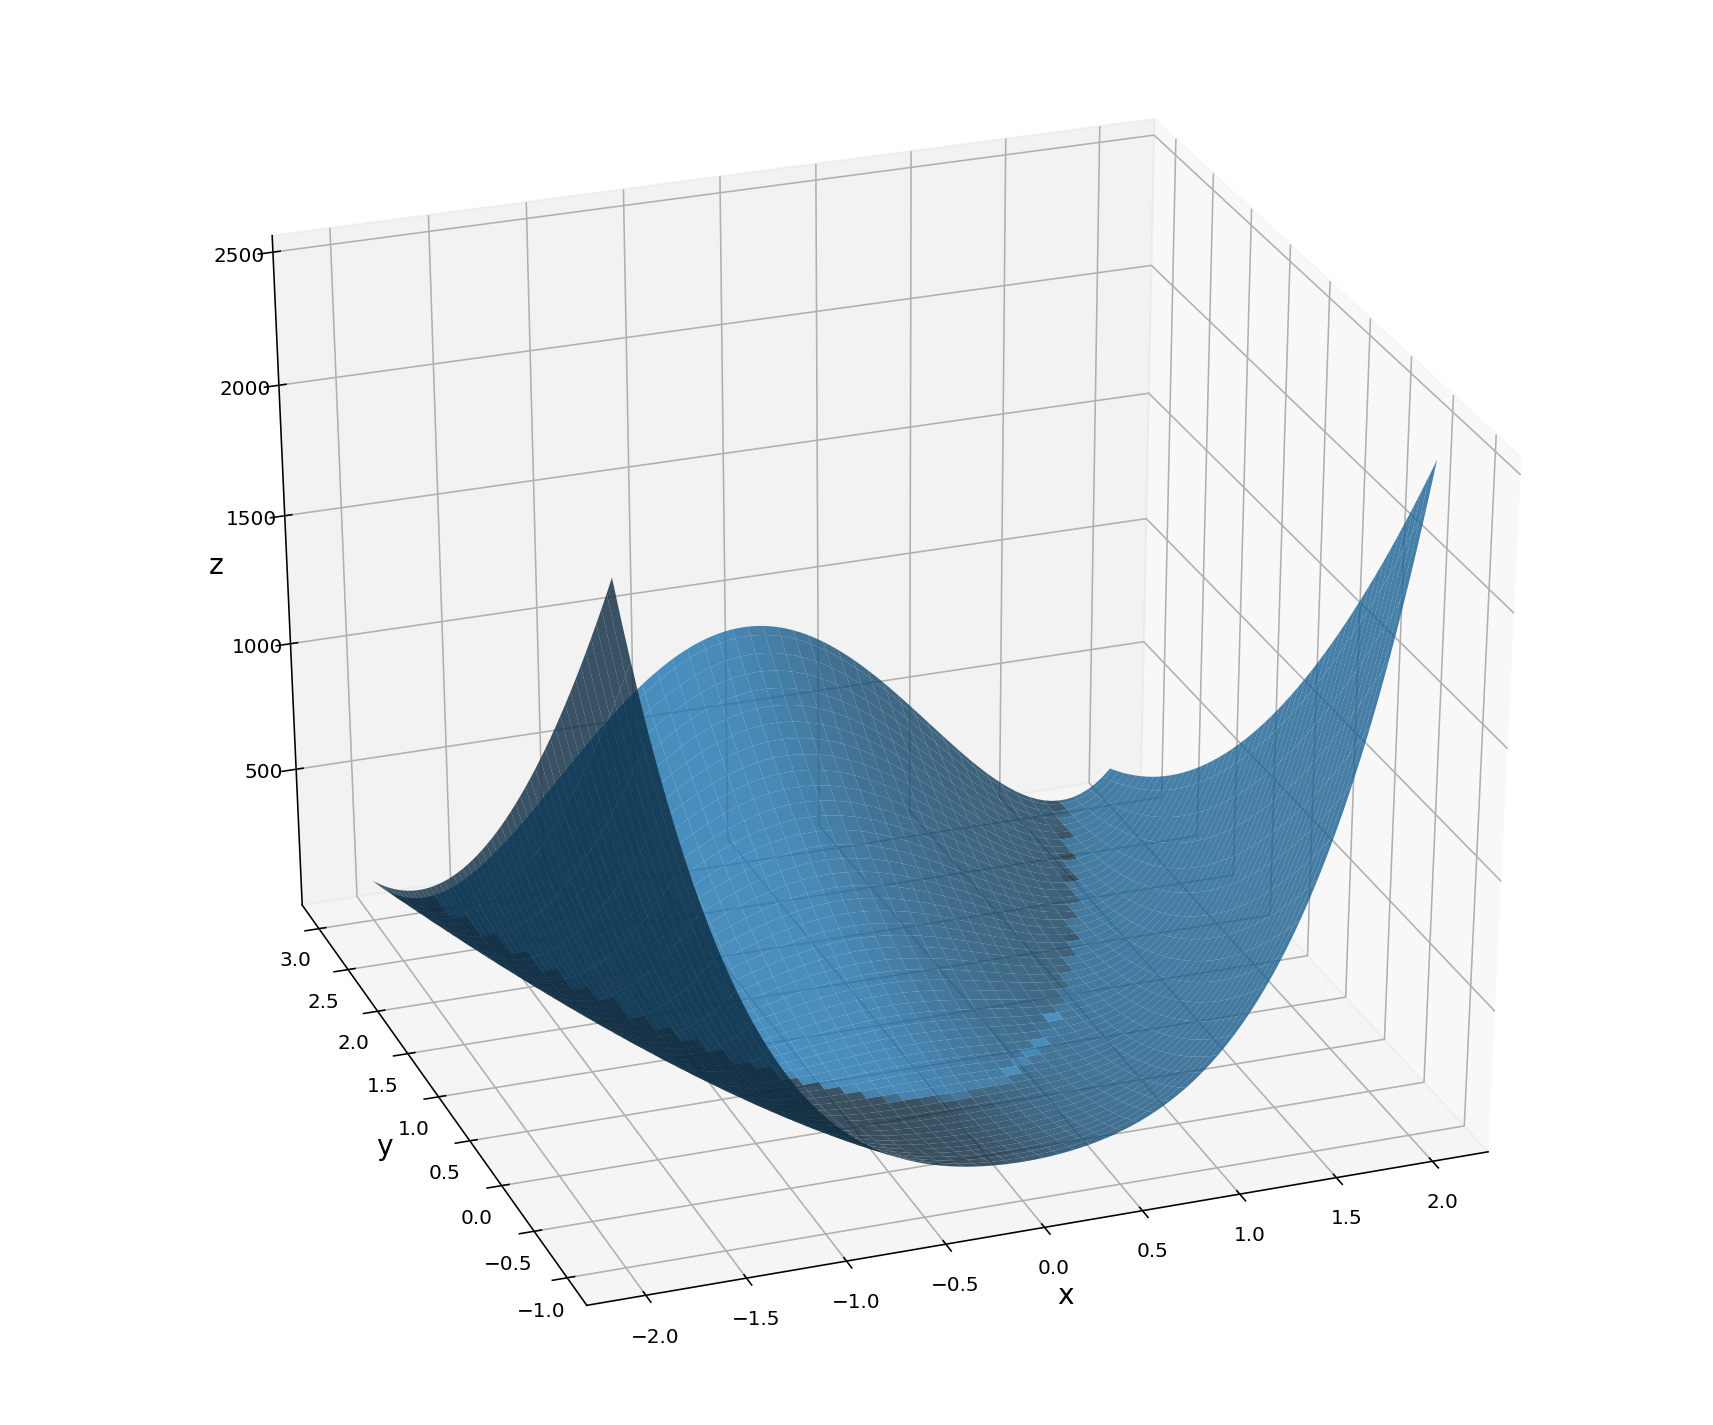

In [692]:
fig = plt.figure(figsize=(12,10))

# Make grid
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x, y)
Z = rosenbrock_func(X, Y)

# Plot the surface
ax = fig.add_subplot(1, 1, 1, projection='3d')
#norm = matplotlib.colors.Normalize(vmin = 0, vmax = 100, clip = True)
#ax.plot_surface(X, Y, Z, alpha=0.8, cmap='viridis_r', norm=norm)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_zlabel('z', fontsize=14)
ax.view_init(30, 250)

plt.tight_layout()

In [557]:
fig.savefig("rosenbrock.png", bbox_inches='tight', dpi=600)

Определим функцию Розенброка:

In [670]:
def func(x):
    return (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2

Для графика

In [711]:
def plot_2d_rosenbrock(s, t):
    xs = []
    ys = []
    
    for i in s:
        xs.append(i[0])
        ys.append(i[1])
    
    plt.figure(figsize=(14, 8))
    
    # Удаляем лишние границы
    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 
    
    # Корректируем оси абсцисс и ординат
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14) 
    
    plt.title("Расположение роя в момент времени t = {}".format(t), fontsize=18)
    plt.xlabel("$x$", fontsize=14)  
    plt.ylabel("$y$", fontsize=14)
    plt.scatter(xs, ys, s=50)

In [712]:
class Particle:    
    def __init__(self, arg, search_space):
        self.pos = np.asarray([])      # расположение частицы
        self.velocity = np.asarray([]) # вектор скорости частицы
        self.pos_best = None           # лучшее расположение 
        
        for i in range(arg):
            pos_i = np.random.uniform(search_space[i][0], search_space[i][1])
            self.pos = np.append(self.pos, pos_i)
            vel_i = np.random.uniform(0.2 * search_space[i][0] , 0.2 * search_space[i][1])
            self.velocity = np.append(self.velocity, vel_i)
        
        # pos_best --- это список, состоящий из лучшего расположения частицы 
        # и значения функции в данной точке
        self.pos_best = [self.pos.copy(), func(self.pos)] 
    
    def update_position(self):
        self.pos += self.velocity
    
    def update_velocity(self, w, c1, c2, swarm_best):
        inertion = w * self.velocity
        cognitive_acceler = c1 * np.random.uniform() * (self.pos_best[0] - self.pos)
        social_acceler = c2 * np.random.uniform() * (swarm_best - self.pos)
        self.velocity = inertion + cognitive_acceler + social_acceler
    
    def choose_personal_best(self):
         if func(self.pos) < func(self.pos_best[0]):
                    self.pos_best[0] = self.pos.copy()
                    self.pos_best[1] = func(self.pos)

In [725]:
class PSO:
    def __init__(self, ell=40, w=1.0, c1=0.2, c2=0.2, max_iter=1000, tol=1e-6):
        """
        PARAMETERS:
        ell --- количество частиц в рое.
        w --- инерционный вес.
        c1 --- коэффициент ускорения когнитивного воздействия на частицу.
        c2 --- коэффициент ускорения социального воздействия на частицу.
        max_iter --- максимальное количество итераций.
        tol --- точность.
        """
        self.ell = ell
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.max_iter = max_iter
        self.tol = tol
        
        self.swarm_best = None # лучшее расположение для всего роя
        self.swarm = None      # расположение всех частиц (рой)
        
    def search_global(self, arg, search_space):
        """
        PARAMETERS:
        arg --- количество аргументов функции.
        search_space --- область поиска оптимума. Задается как список из кортежей, где 
        кортеж --- это область значений одного аргумента функции.
        """
        self.arg = arg
        self.search_space = np.array(search_space)
        self.swarm = np.asarray([])
        
        # генерируем расположение роя 
        for _ in range(self.ell):
            self.swarm = np.append(self.swarm, 
                                   Particle(self.arg, self.search_space))
        # для графика 
        x_0 = [self.swarm[i].pos for i in range(self.ell)]
        plot_2d_rosenbrock(x_0, 0)
        
        for k in range(self.max_iter):
            for i in range(self.ell):
                # обновляем расположение частицы
                self.swarm[i].update_position()
                # сравниваем с лучшей точкой частицы
                self.swarm[i].choose_personal_best()
            
            # выбираем лучшую точку для роя
            if k != 0:
                dist_0 = self.dist(self.swarm_best[0])
                self.choose_social_best()
                dist_1 = self.dist(self.swarm_best[0])
                
                # останавливаем поиск в условиях заданной точности
                if (dist_0 != dist_1) and (abs(dist_0 - dist_1) <= self.tol):
                    # для графика
                    x_k = [self.swarm[i].pos for i in range(self.ell)]
                    plot_2d_rosenbrock(x_k, k)
                    break
            else:
                self.choose_social_best()
                
            # для графика
            if k == 100:
                x_100 = [self.swarm[i].pos for i in range(self.ell)]
                plot_2d_rosenbrock(x_100, k)
            
            # для графика
            if k == 300:
                x_300 = [self.swarm[i].pos for i in range(self.ell)]
                plot_2d_rosenbrock(x_300, k)
                
            if k == 500:
                x_500 = [self.swarm[i].pos for i in range(self.ell)]
                plot_2d_rosenbrock(x_300, k)
            
            if k == 800:
                x_800 = [self.swarm[i].pos for i in range(self.ell)]
                plot_2d_rosenbrock(x_300, k)
                
            # обновляем вектор скорости
            for i in range(self.ell):
                self.swarm[i].update_velocity(self.w, self.c1, self.c2, self.swarm_best[0])
        
        # для графика
        x_k = [self.swarm[i].pos for i in range(self.ell)]
        plot_2d_rosenbrock(x_k, k)
        
        print(f"Глобальный оптимум: {self.swarm_best[0]}.")
        print(f"Значение функции в данной точке: {self.swarm_best[1]}.")
        
        
    def choose_social_best(self):
        self.swarm_best = min([[self.swarm[i].pos_best[0], 
                                self.swarm[i].pos_best[1]] for i in range(self.ell)],
                                key=lambda x: x[1])
        
    def dist(self, x):
        return np.sqrt(np.sum(x ** 2))

In [726]:
a = PSO(w=0.95, ell=100, tol=1e-20)

Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 9.921581352137256e-23.


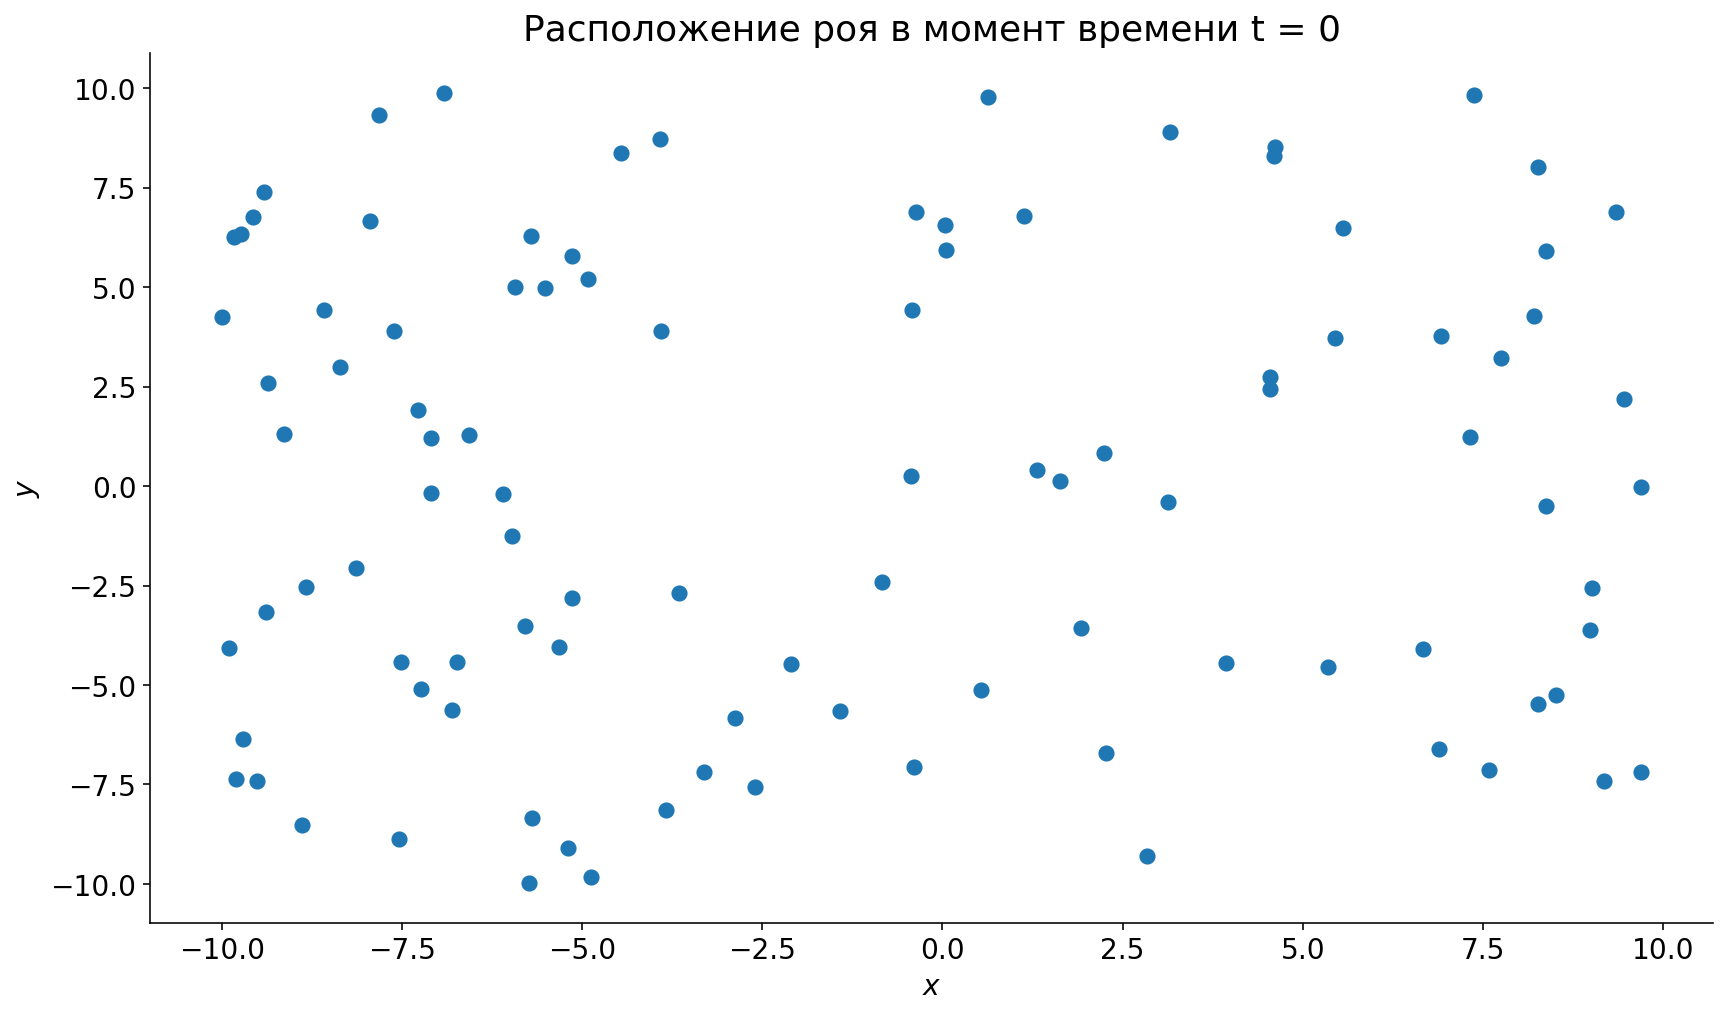

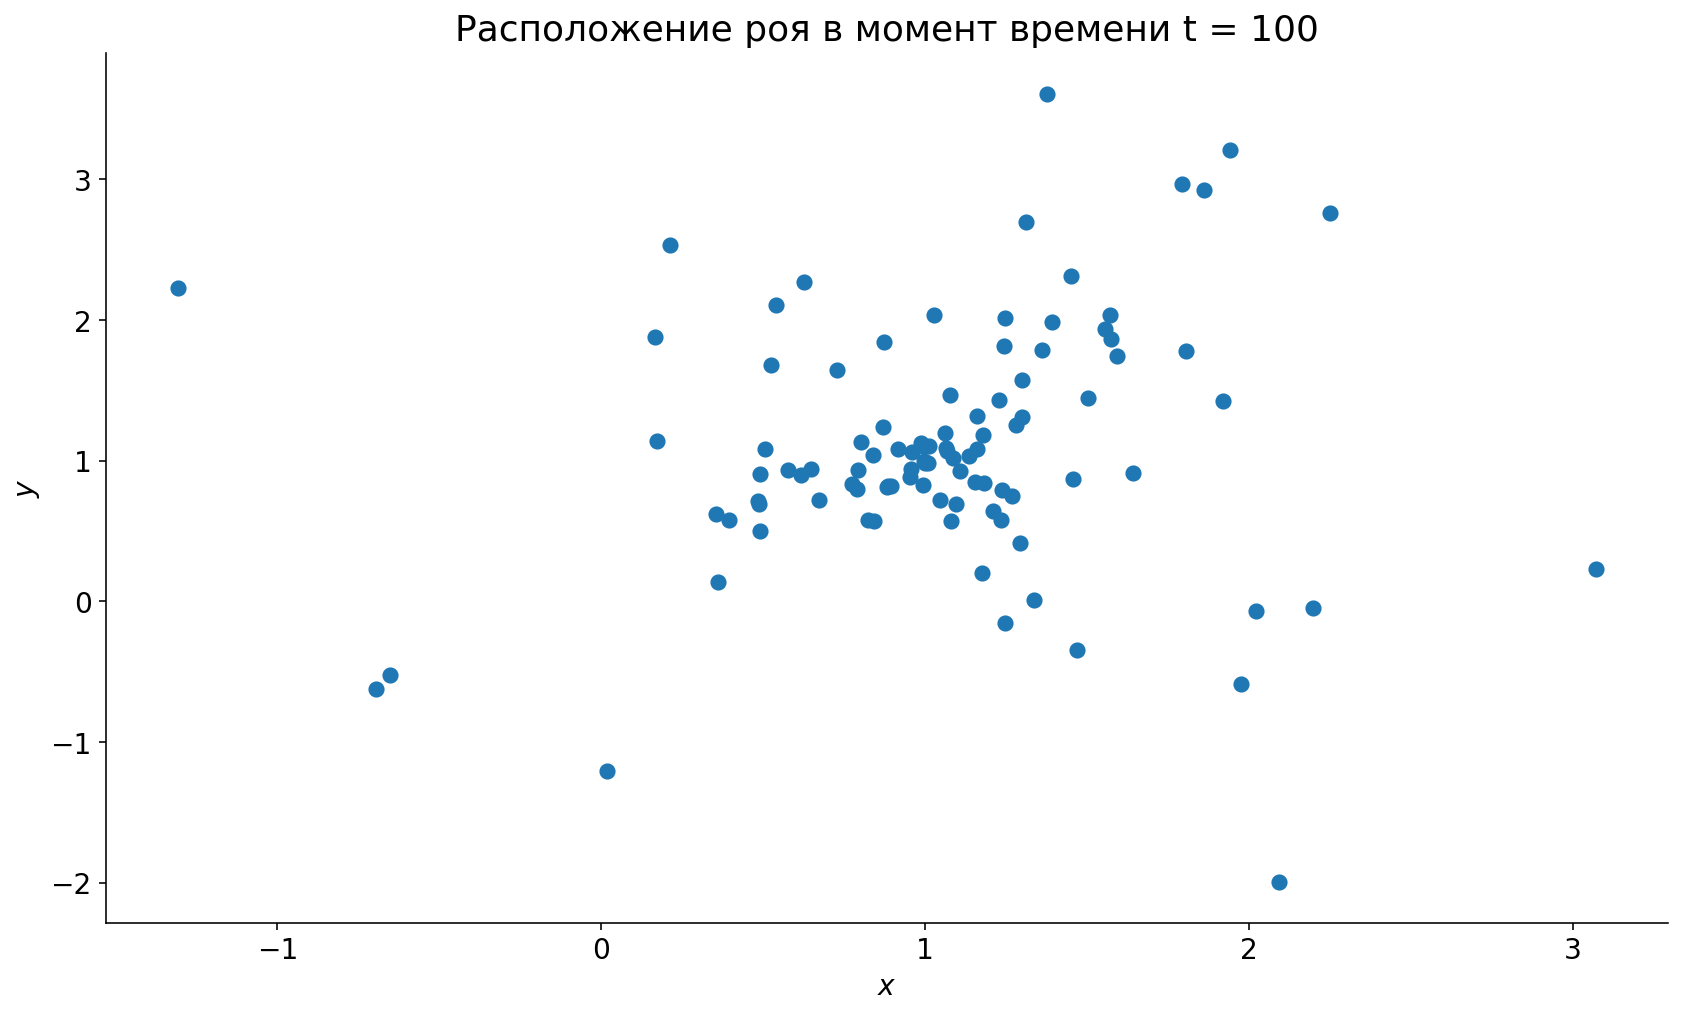

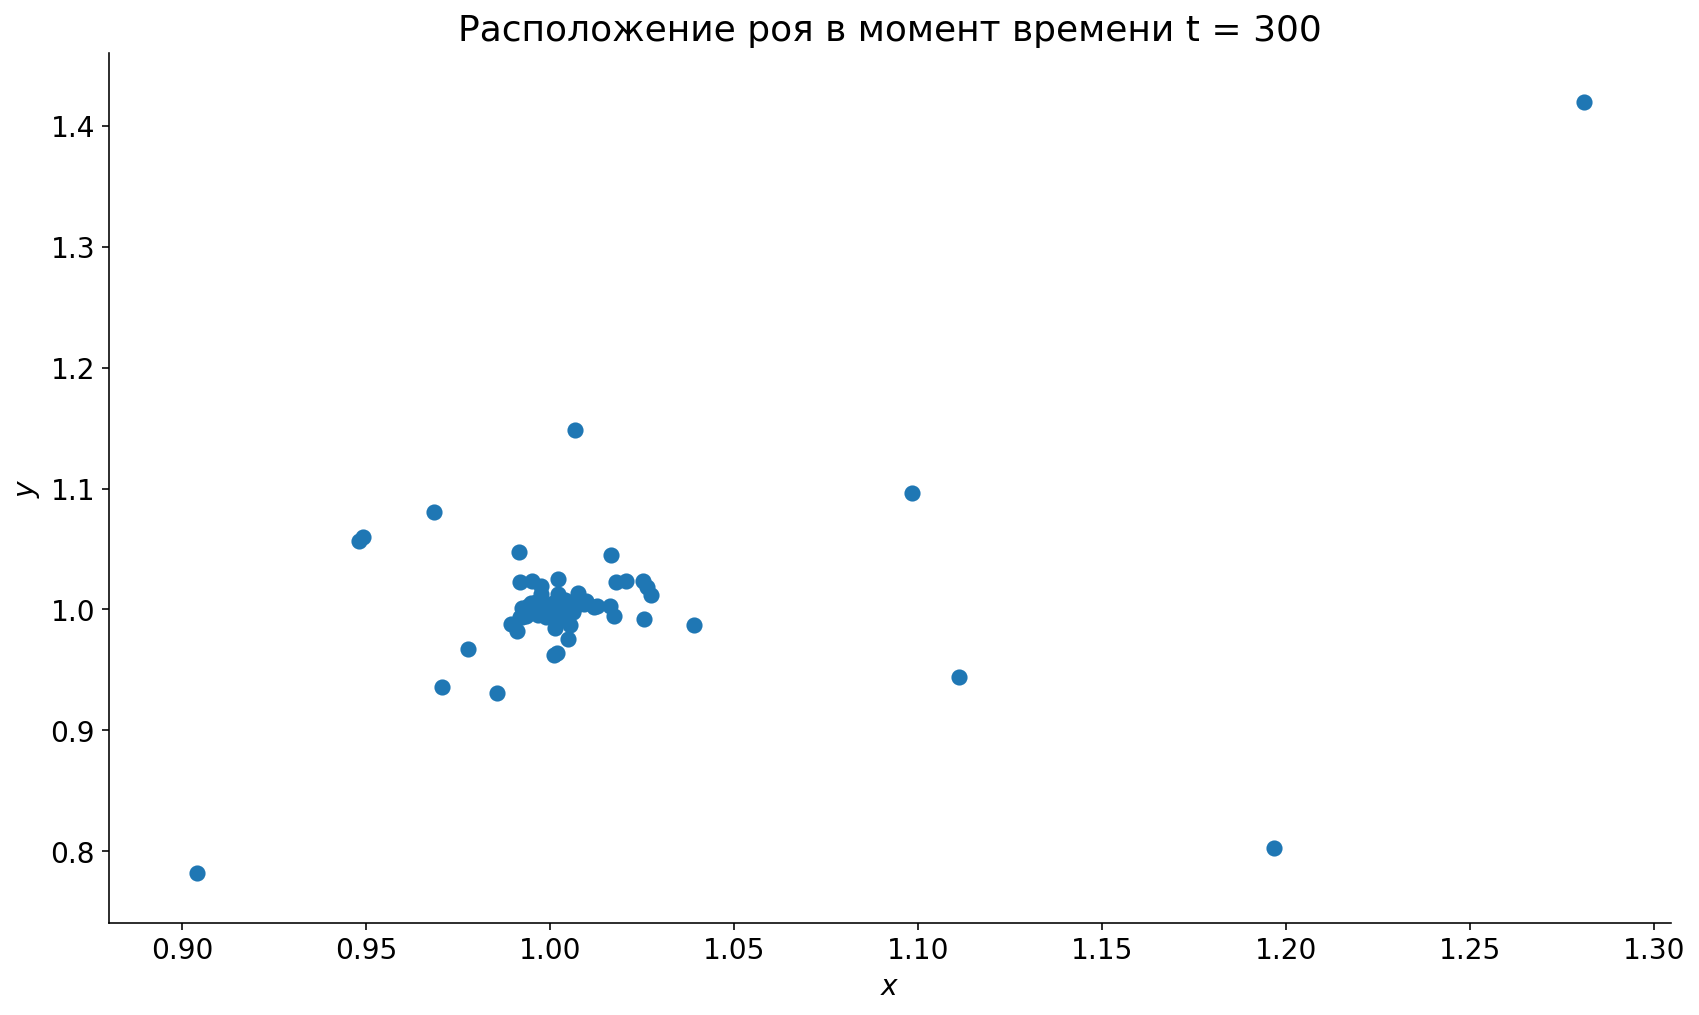

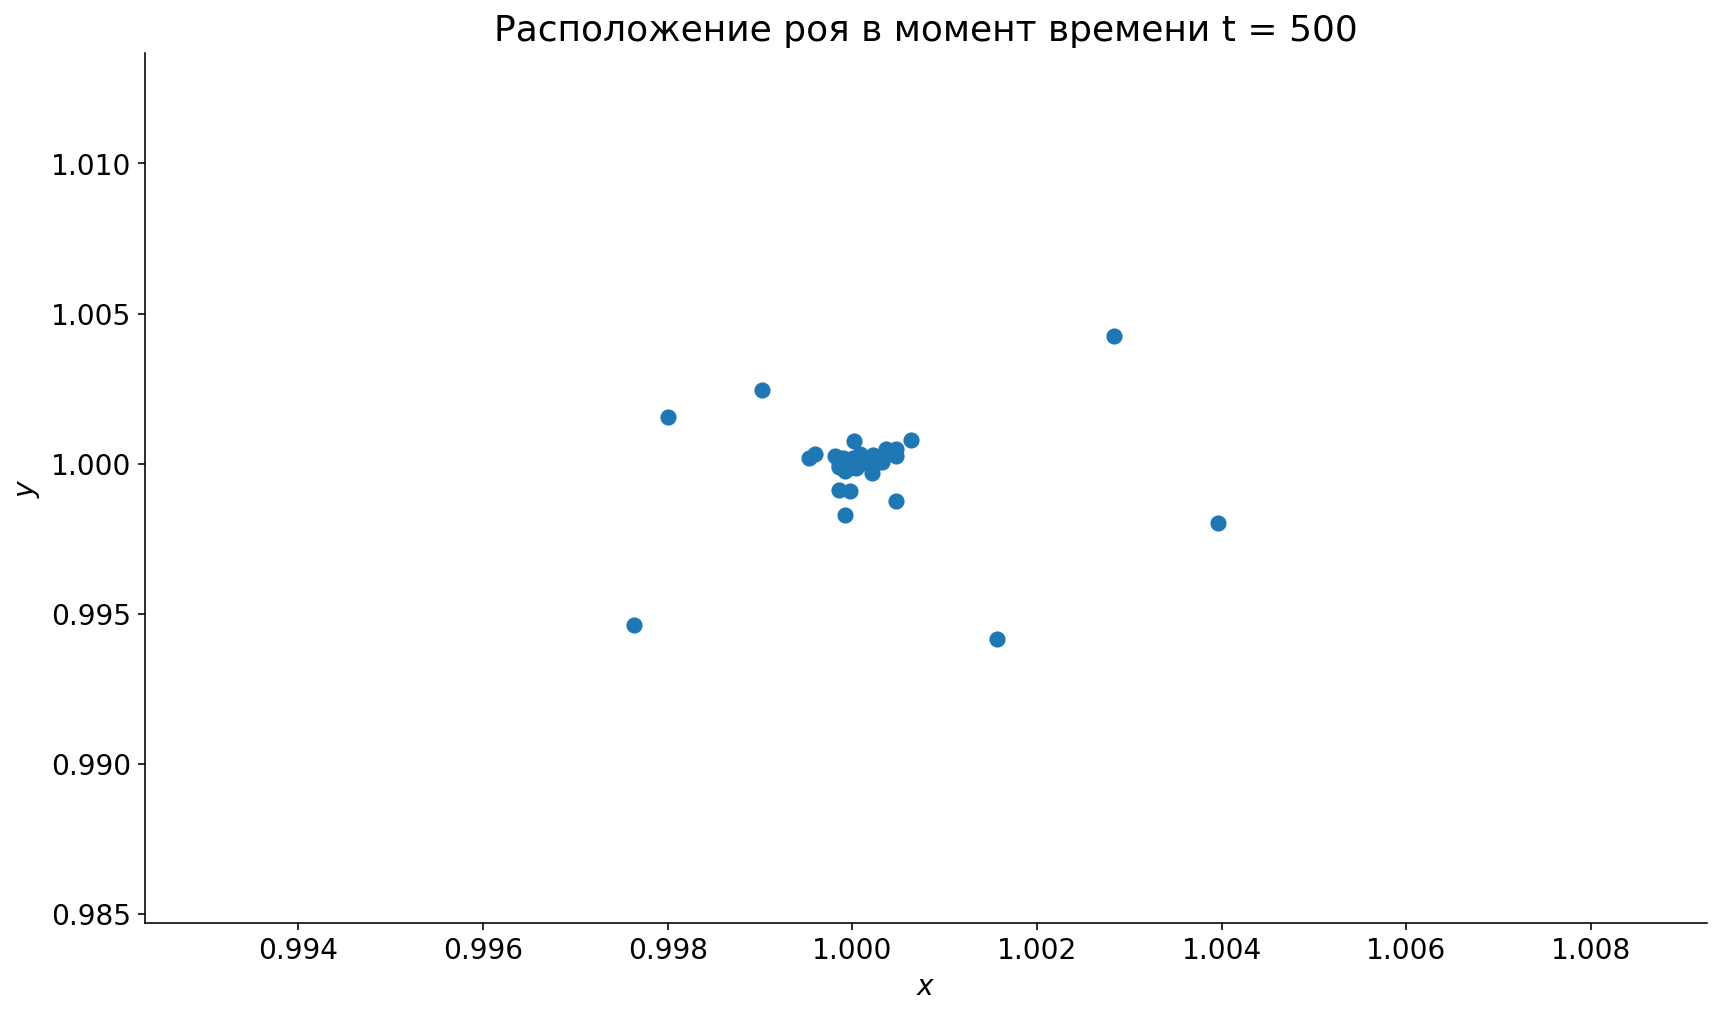

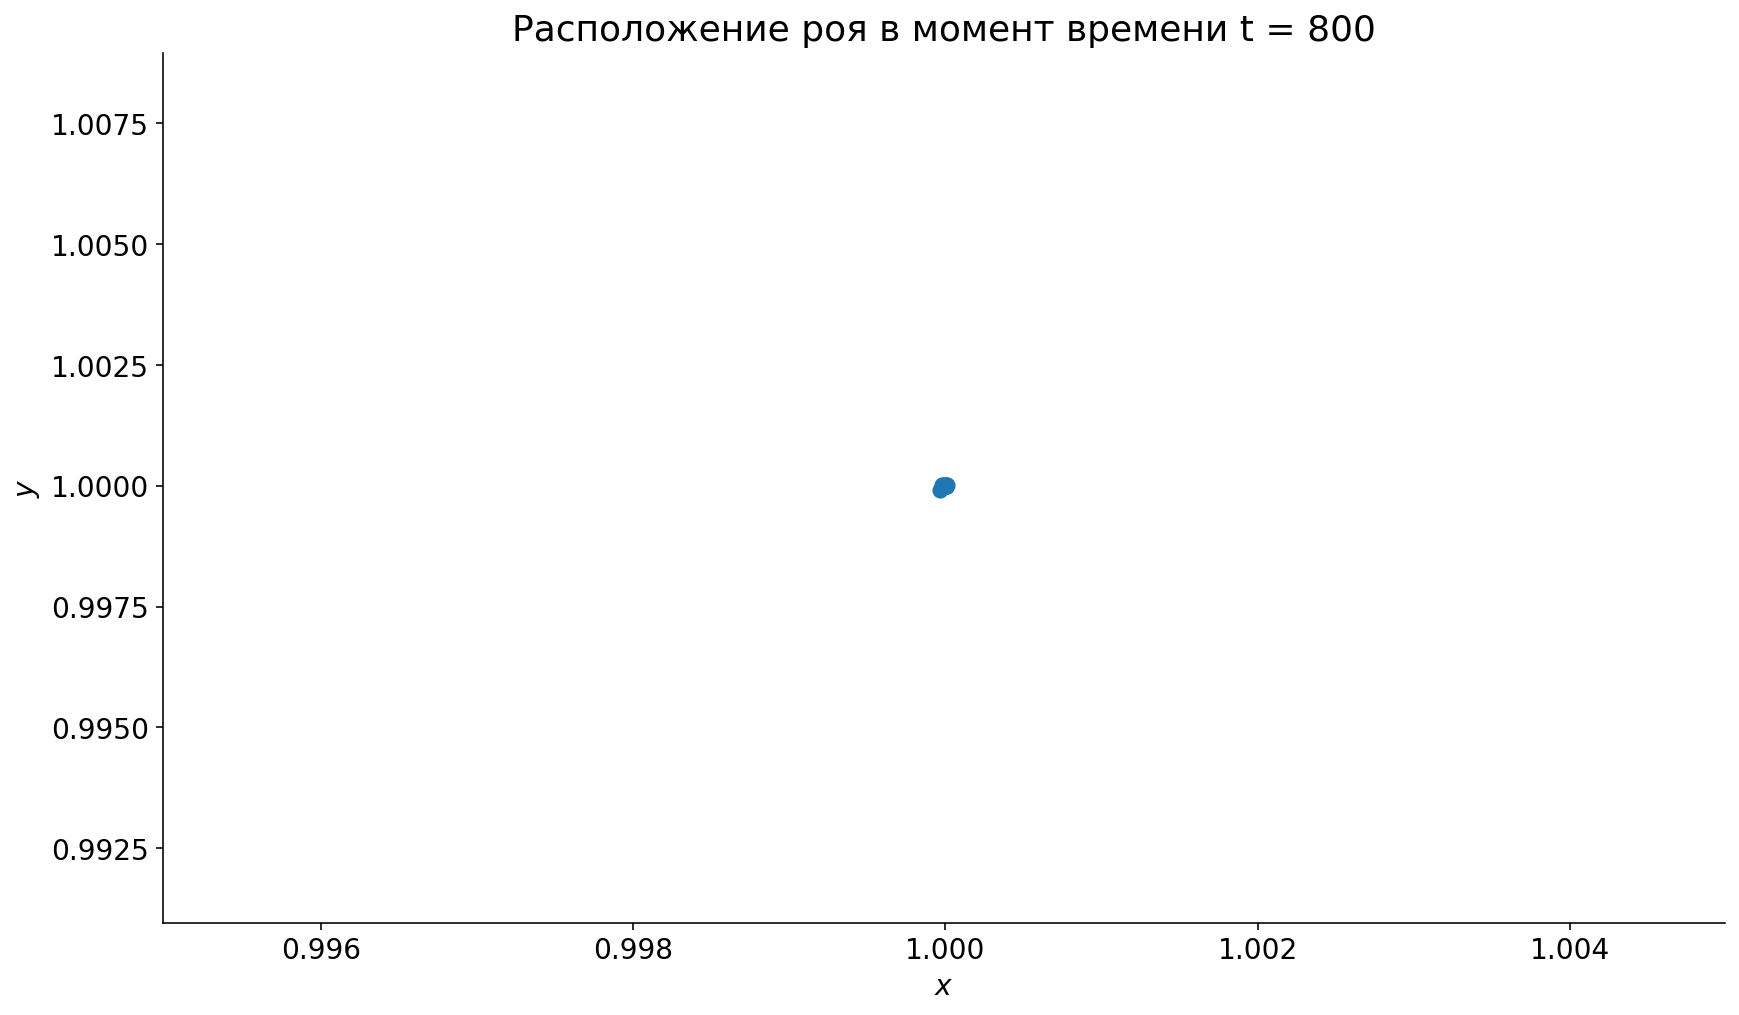

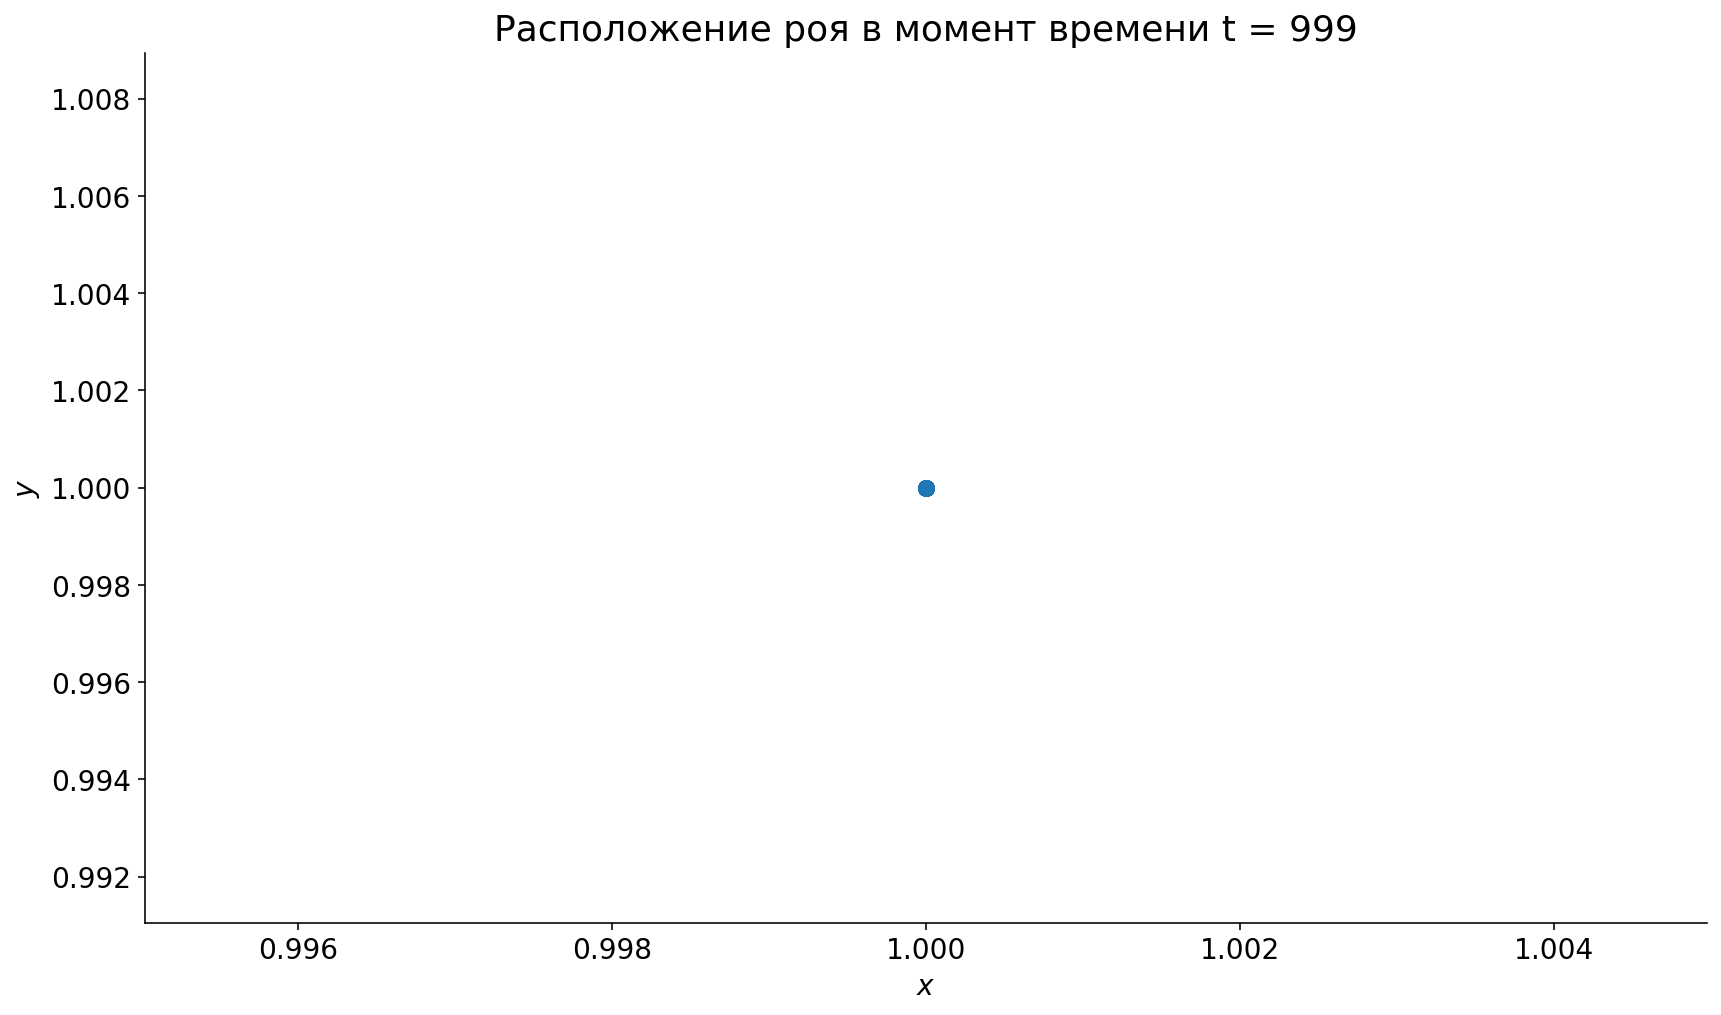

In [730]:
np.random.seed(13)
a.search_global(2, [(-10, 10),(-10, 10)])